# Quantum Algorithm as a PDE solver- 1D Burgers' Equation for CFD
In this notebook we solved the Burgers’ PDE using:
1. Quantum Tensor Network (QTN)
2. Hydrodynamic Schrodinger Equation (HSE)
3. Real QPU via Amazon Braket (Rigetti)

## Section 1: Quantum Tensor Network (QTN)

In this section we simulates the quantum evolution of a 1D Burgers’ Equation using the QTN (Quantum Tensor Network) approach, followed by-
- 2 Qubits i.e. 4 Grid Points
- Outputs probability of basis states (e.g., |00>, |01>, |10>, |11> ) over time
- 4 Qubits i.e. 16 Grid Points
- Outputs probability of basis states (e.g., |0000>, |0001>, so on..) over time
- Observing various Plot and Analysis them

# Overview of the Quantum Tensor Network (QTN) 

- It is a method where a complex and high-dimensional system is broken down into simpler components using **matrix product states (MPS).** It can be denoted as a modular unit combining gates like rotation, entanglement and measurement. In a real QTN, each MSP block could correspond to a Trotterized timestep, simulating Hamiltonian evolution.
- First, we **discretize the domain** Using 4 grid points (2 qubits), then 16 grid points (4 qubits).

- Each point on the grid corresponds to a **qubit amplitude, forming a quantum state.**

- Now, **QTN** = applying a tensorized set of unitary gates to evolve the quantum state represented by u(x)

- **Encoding** i.e. mapping classical vector u0, u1, etc into quantum amplitudes.

- **Time Evolution** i.e. applying a quantum circuit (approximating Burgers’ operator via Trotterization).

- **Measurement** i.e. reading back values ui(t) from qubit measurement.

## Understanding the concept in a mathematical way

- We know **u(x,t) is a velocity as a function** of space or position x and time t in the Burgers equation.
- Now we will discretize space into N = 4 grid points which will become a quantum state with 4 amplitudes, and required qubits=2.
- Assuming we have **classical initial values of u(x,t=0)** as (u0,u1,u2,u3) = (0.2,0.5,0.7,0.4)
- Now we **normalize** this to make it a valid quantum state as **Norm(u)** which is equivalent to 0.97
- Hence the **quantum amplitudes** become (u0/0.97, u1/0.97,u2/0.97, u3/0.97) represented by ψ0 = (0.206,0.515,0.721,0.412)
- So finally our **quantum state (2 qubits, 4 amplitudes) as |ψ0>** = 0.206|00> + 0.515|01> + 0.721|10> + 0.412|11> **where each basis  state |i> corresponds to a spatial grid point**
- Now **QTN approximates time evolution** by applying a tensorized unitary operator, simulating the effect of Burgers' dynamics. This is done **layer-by-layer using unitary gates** like: Single-qubit rotations (e.g., Ry(θ)), entangling gates (e.g., CNOT) and repeated over Trotter steps.

#### Importing necessary libraries

In [1]:
import numpy as np
from pennylane import numpy as pnp
import pennylane as qml
import matplotlib.pyplot as plt

# For 2 Qubits (4 Grid Points)

#### Set hyperparameters

In [2]:
n_qubits = 2               # start with 2 qubits = 4 grid points
grid_size = 2 ** n_qubits  # Total spatial resolution
nu = 0.01                  # Viscosity
dt = 0.1                   # Time step size
n_steps = 20               # Total number of Time steps 

- Each time step = 1 round of applying gates to simulate convection + diffusion.
- Let's we want to simulate 20 time steps. So total simulated time = n_steps * dt = 20 * 0.1 = 2.0 time units.

#### Initial condition - step function

In [3]:
def initial_condition(grid_size):
    x = np.linspace(0, 1, grid_size) # x is the spatial coordinate
    u0 = np.where(x < 0.5, 1.0, 0.0) 
    norm = np.linalg.norm(u0)
    return u0 / norm

u0 = initial_condition(grid_size) 

- Above is a simple step function u(x)=1 for x<0.5, 0 otherwise

#### Define the QTN-based circuit

In [4]:
dev = qml.device("default.qubit", wires=n_qubits) # Set up the Quantum Device

# Burgers' evolution:

def trotter_layer(params, t):                       # params: Trainable parameters that are time-evolving angles
    # Apply Trotterized layer for time t
    for i in range(n_qubits - 1):
        qml.CRX(2 * dt * params[i], wires=[i, i+1]) # CRX: simulates diffusion between neighbors i.e. interaction term
    for i in range(n_qubits):
        qml.RY(-dt * params[-1], wires=i)    # RY: models local nonlinear convective term i.e. rotates individual grid points

- Each trotter_layer() applies quantum gates that mimic diffusion and convection. This quantum circuit is designed to approximate the time evolution operator of the Burgers’ equation.

 #### MottonenStatePreparation

In [5]:
@qml.qnode(dev)
def qtn_circuit(params, steps=n_steps):
    qml.MottonenStatePreparation(u0, wires=range(n_qubits)) #prepares the initial condition u0 as a quantum state on our qubits.
    for t in range(steps):
        trotter_layer(params, t)
    return qml.probs(wires=range(n_qubits))

- Here this circuit is used for partial or full evolution.it simulates the quantum system up to a specific time steps(let's steps=1.0) or total time steps (when steps=n_steps)
- MottonenStatePreparation is a quantum gate-based routine that prepares any arbitrary quantum state (real or complex amplitudes) on a set of qubits.

#### Define Params

In [6]:
# Makes params compatible with PennyLane’s autograd system.
# requires_grad=True - Explicitly flags it as trainable.
params = pnp.array(np.random.uniform(0, np.pi, size=(n_qubits,)), requires_grad=True)

- Parameters are passed into our quantum circuit gates - determines how strongly diffusion and convection are applied in our circuit.
- params[i] simulates diffusion between neighboring points (non-unitary coupling). params[-1] simulates convection at each point (local rotation).
- params are learned or fine-tuned during training to match the physical dynamics of our PDE (like the Burgers' equation).

#### Circuit Diagram

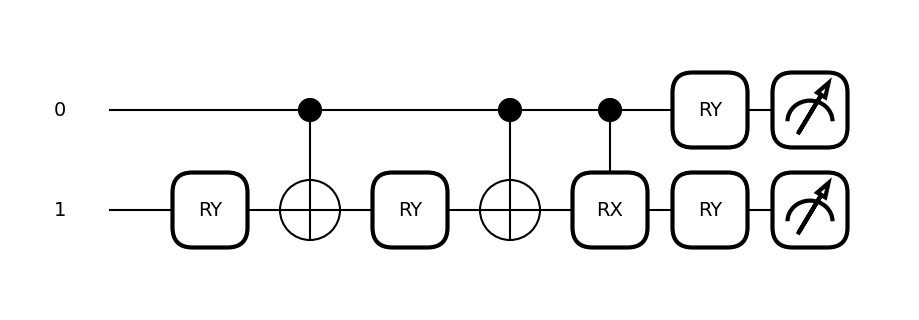

In [7]:
import matplotlib.pyplot as plt

fig, ax = qml.draw_mpl(qtn_circuit, level="device")(params, steps=1)
plt.show()

#### Target: simple diffused distribution

In [8]:
target = np.linspace(1.0, 0.0, grid_size)    # A linearly decreasing velocity field across space
target = target / np.linalg.norm(target)     # Normalized to match quantum state's unit norm constraint

- In terms of the Burgers’ equation, it mimics a diffused, smoothed-out velocity profile after some evolution time — like a final state we want the quantum circuit to reach.

####  Cost function

In [9]:
def cost_fn(params):
    probs = qtn_circuit(params)
    return pnp.sum((probs - target) ** 2)

#### Optimization loop and Cost estimation

In [10]:
# Optimization loop
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
costs = []

params = params.copy()
for i in range(steps):
    params = opt.step(cost_fn, params)
    c = cost_fn(params)
    costs.append(c)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {c:.5f}")

Step 0: Cost = 0.31128
Step 10: Cost = 0.22235
Step 20: Cost = 0.15283
Step 30: Cost = 0.13187
Step 40: Cost = 0.12804
Step 50: Cost = 0.12654
Step 60: Cost = 0.12582
Step 70: Cost = 0.12545
Step 80: Cost = 0.12524
Step 90: Cost = 0.12512


- **Observing** Cost started at 0.31128 and reduced to 0.12512. The lower the cost, the closer our quantum model's output is to the target.

#### Final Probability Distribution After Training

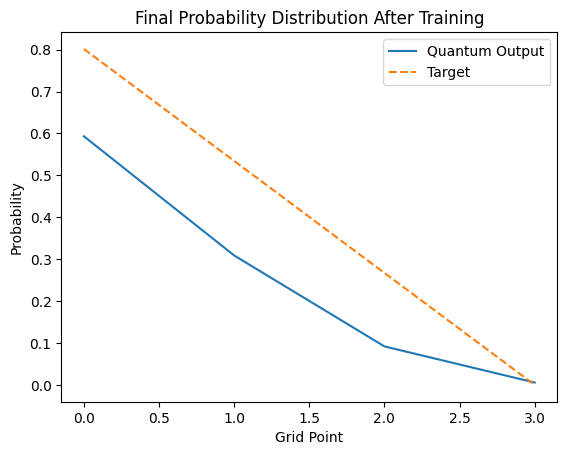

In [11]:
final_probs = qtn_circuit(params)

plt.plot(final_probs, label='Quantum Output')
plt.plot(target, '--', label='Target')
plt.title("Final Probability Distribution After Training")
plt.xlabel("Grid Point")
plt.ylabel("Probability")
plt.legend()
plt.show()

- probability at a grid point indicate likelihood of finding "fluid" at that position.As time evolves, this probability changes due to quantum operations (Trotterization). This plot here shows the spatial distribution of the system at the final time.
- **Observing** initially, the system had a step function (discontinuous) velocity field.
- After quantum evolution and optimization, it approximates a smooth decay, consistent with how the viscosity diffuses sharp gradients in Burgers’ PDE.

#### Collecting probability at a specific grid point

In [12]:
# let's at center Grid Point over time
time_series = []
prob_series = []

for step in range(n_steps + 1):
    probs = qtn_circuit(params, step)
    time_series.append(step * dt)
    prob_series.append(probs[grid_size // 2])  # picking the center point

- 2 qubits gives 4 states that is 00, 01, 10, 11 with index 0 to 3. These basis states form the quantum probability distribution over space.
- P(00), P(01), P(10), P(11) indicates probs[0], probs[1], probs[2], probs[3] respectively. Now grid_size // 2 = 2 so it picks index 2.(that is center point)

#### Probability Distribution at Center Grid Point

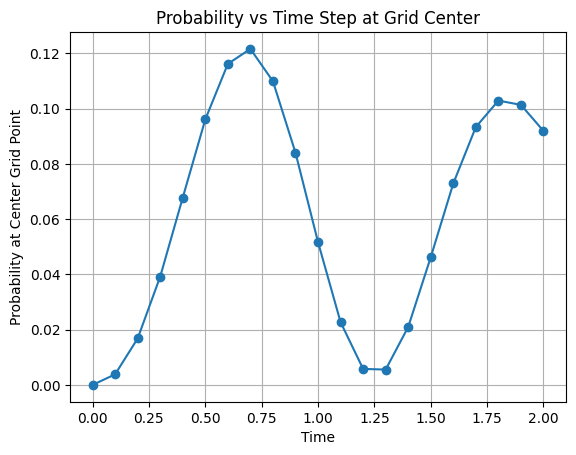

In [13]:
plt.plot(time_series, prob_series, marker='o')
plt.title("Probability vs Time Step at Grid Center")
plt.xlabel("Time")
plt.ylabel("Probability at Center Grid Point")
plt.grid(True)
plt.show()

- This plot shows how the “fluid density” at the location of a single grid point evolves over time.
- it is like monitoring how the “height of water” at the midpoint changes over time.

#### Collecting probability at the starting grid point

In [14]:
time_series = []
prob_series = []

for step in range(n_steps + 1):
    probs = qtn_circuit(params, step)
    time_series.append(step * dt)
    prob_series.append(probs[grid_size //4 ])  # picking the starting grid point

#### Probability Distribution at Starting Grid Point

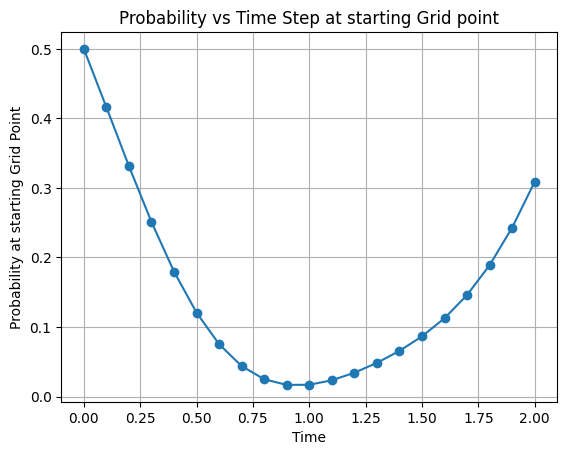

In [15]:
plt.plot(time_series, prob_series, marker='o')
plt.title("Probability vs Time Step at starting Grid point")
plt.xlabel("Time")
plt.ylabel("Probability at starting Grid Point")
plt.grid(True)
plt.show()

# For 4 Qubits (16 Grid Points)

#### Set hyperparameters

In [16]:
n_qubits = 4               # start with 4 qubits = 16 grid points
grid_size = 2 ** n_qubits  # Total spatial resolution
nu = 0.01                  # Viscosity
dt = 0.1                   # Time step size
n_steps = 20               # Total number of Time steps 

#### Initial condition - step function

In [17]:
def initial_condition(grid_size):
    x = np.linspace(0, 1, grid_size) # x is the spatial coordinate
    u0 = np.where(x < 0.5, 1.0, 0.0) 
    norm = np.linalg.norm(u0)
    return u0 / norm

u0 = initial_condition(grid_size)

#### Define the QTN-based circuit

In [18]:
dev = qml.device("default.qubit", wires=n_qubits) # Set up the Quantum Device

# Burgers' evolution:

def trotter_layer(params, t):                       # params: Trainable parameters that are time-evolving angles
    # Apply Trotterized layer for time t
    for i in range(n_qubits - 1):
        qml.CRX(2 * dt * params[i], wires=[i, i+1]) # CRX: simulates diffusion between neighbors i.e. interaction term
    for i in range(n_qubits):
        qml.RY(-dt * params[-1], wires=i)    # RY: models local nonlinear convective term i.e. rotates individual grid points

#### MottonenStatePreparation

In [19]:
@qml.qnode(dev)
def qtn_circuit(params, steps=n_steps):
    qml.MottonenStatePreparation(u0, wires=range(n_qubits)) #prepares the initial condition u0 as a quantum state on our qubits.
    for t in range(steps):
        trotter_layer(params, t)
    return qml.probs(wires=range(n_qubits))

#### Define Params

In [20]:
# Makes params compatible with PennyLane’s autograd system.
# requires_grad=True - Explicitly flags it as trainable.
params = pnp.array(np.random.uniform(0, np.pi, size=(n_qubits,)), requires_grad=True)

#### Circuit Diagram

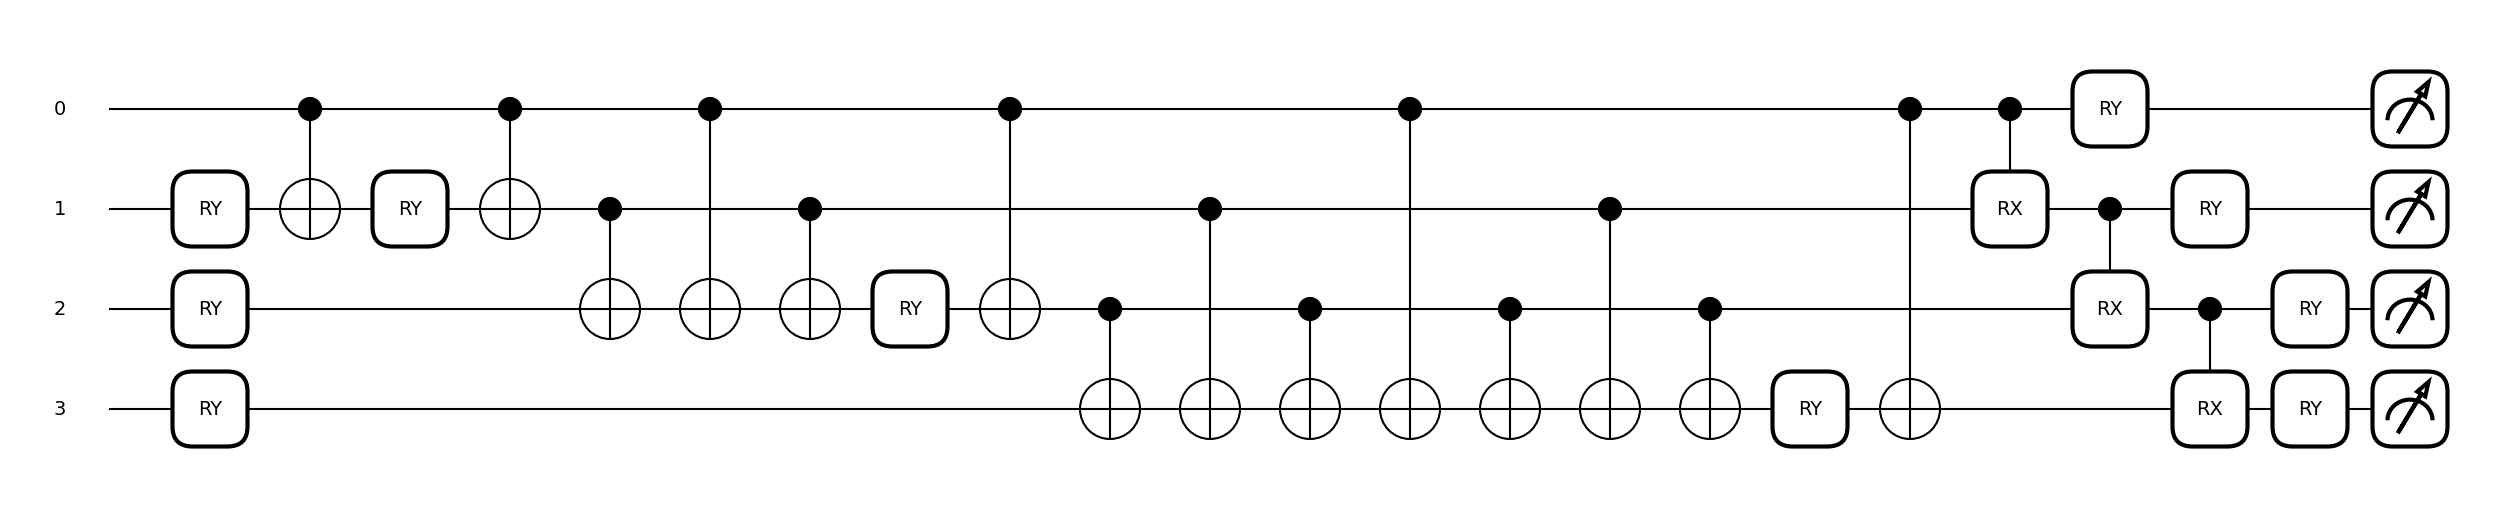

In [21]:
import matplotlib.pyplot as plt

fig, ax = qml.draw_mpl(qtn_circuit, level="device")(params, steps=1)
plt.show()

#### Target: simple diffused distribution

In [22]:
target = np.linspace(1.0, 0.0, grid_size)    # A linearly decreasing velocity field across space
target = target / np.linalg.norm(target)     # Normalized to match quantum state's unit norm constraint

#### Cost function

In [23]:
def cost_fn(params):
    probs = qtn_circuit(params)
    return pnp.sum((probs - target) ** 2)

#### Optimization loop and Cost estimation

In [24]:
# Optimization loop
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
costs = []

params = params.copy()
for i in range(steps):
    params = opt.step(cost_fn, params)
    c = cost_fn(params)
    costs.append(c)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {c:.5f}")

Step 0: Cost = 0.47543
Step 10: Cost = 0.46399
Step 20: Cost = 0.46287
Step 30: Cost = 0.46206
Step 40: Cost = 0.46147
Step 50: Cost = 0.46106
Step 60: Cost = 0.46077
Step 70: Cost = 0.46056
Step 80: Cost = 0.46042
Step 90: Cost = 0.46032


- **Observing** Cost started at 0.47543 and reduced to 0.46032

#### Final Probability Distribution After Training

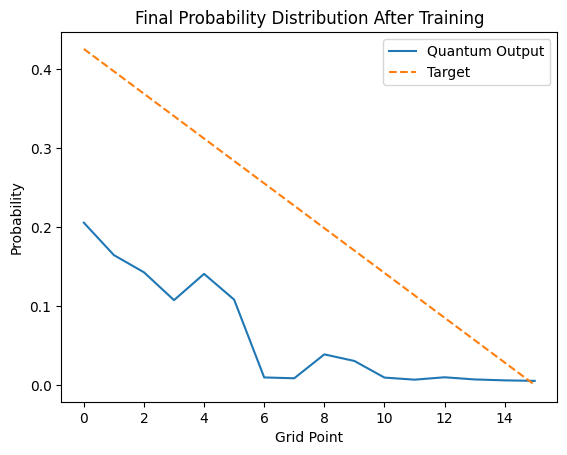

In [25]:
final_probs = qtn_circuit(params)

plt.plot(final_probs, label='Quantum Output')
plt.plot(target, '--', label='Target')
plt.title("Final Probability Distribution After Training")
plt.xlabel("Grid Point")
plt.ylabel("Probability")
plt.legend()
plt.show()

- **Observing** it does not follow the smooth linear shape of the target.

## Improvement using Adam Optimizer

In [26]:
# Optimization loop
opt = qml.AdamOptimizer(stepsize=0.1)
steps = 100
costs = []

params = params.copy()
for i in range(steps):
    params = opt.step(cost_fn, params)
    c = cost_fn(params)
    costs.append(c)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {c:.5f}")

Step 0: Cost = 0.46775
Step 10: Cost = 0.45768
Step 20: Cost = 0.45057
Step 30: Cost = 0.44894
Step 40: Cost = 0.44890
Step 50: Cost = 0.44864
Step 60: Cost = 0.44863
Step 70: Cost = 0.44863
Step 80: Cost = 0.44861
Step 90: Cost = 0.44861


- **Observing** Cost started at 0.46775 and reduced to 0.44861

#### Final Probability Distribution After Training

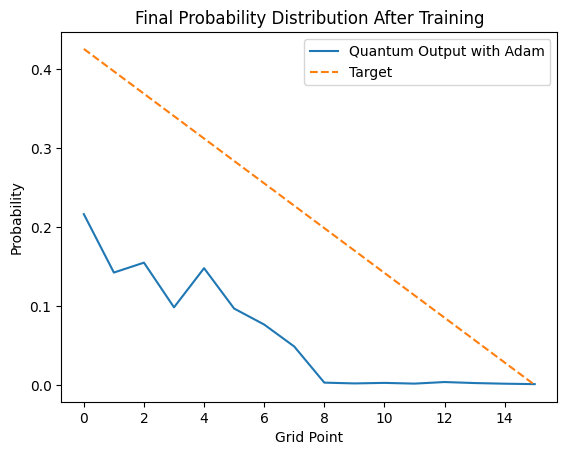

In [27]:
final_probs = qtn_circuit(params)

plt.plot(final_probs, label='Quantum Output with Adam')
plt.plot(target, '--', label='Target')
plt.title("Final Probability Distribution After Training")
plt.xlabel("Grid Point")
plt.ylabel("Probability")
plt.legend()
plt.show()

#### Collecting probability at a specific grid point

In [28]:
# let's at center Grid Point over time
time_series = []
prob_series = []

for step in range(n_steps + 1):
    probs = qtn_circuit(params, step)
    time_series.append(step * dt)
    prob_series.append(probs[grid_size // 2])  # picking the center point

#### Probability Distribution at Center Grid Point

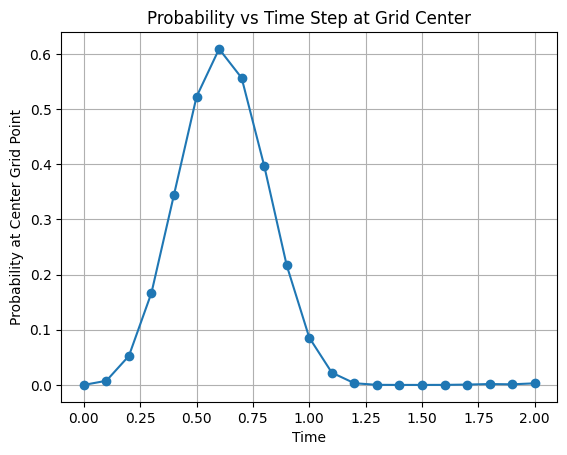

In [29]:
plt.plot(time_series, prob_series, marker='o')
plt.title("Probability vs Time Step at Grid Center")
plt.xlabel("Time")
plt.ylabel("Probability at Center Grid Point")
plt.grid(True)
plt.show()

#### Collecting probability at the starting grid point

In [30]:
time_series = []
prob_series = []

for step in range(n_steps + 1):
    probs = qtn_circuit(params, step)
    time_series.append(step * dt)
    prob_series.append(probs[grid_size //16])  # picking the starting grid point

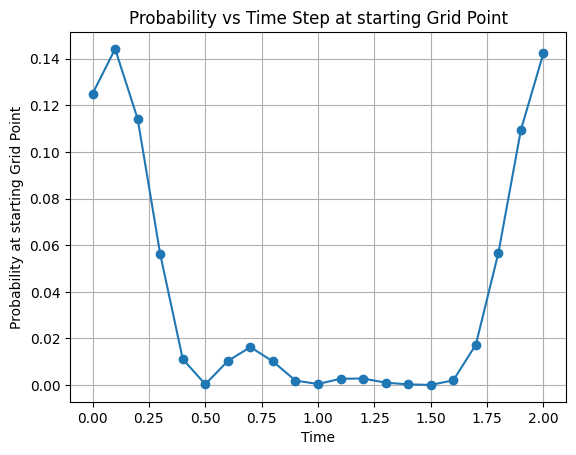

In [31]:
plt.plot(time_series, prob_series, marker='o')
plt.title("Probability vs Time Step at starting Grid Point")
plt.xlabel("Time")
plt.ylabel("Probability at starting Grid Point")
plt.grid(True)
plt.show()